In [8]:
from config import *
import pandas as pd
import os
result_directory = result_parent_directory + os.sep + "step0_data_preparation_and_analysis"
os.makedirs(result_directory, exist_ok=True)
figures_directory = result_directory

In [9]:
# load data
df = pd.read_csv(path_Sim_original_data, dtype = dtype_Sim, index_col= "time") #, usecols= ["time", "vehicle", "parkingTaz", "arrivalTime", "departureTime", "duration", "fuel", "chargingPointType", "vehicleType"])

In [10]:
# delete all rows which are not RefuelSessionEvents
print(len(df))
df = df[df["type"] == "RefuelSessionEvent"]
print(len(df))
# delete all rows with time higher than 24 hours
df = df[df.index <= 24*60*60]
print(len(df))
# save new file
df.to_csv(path_Sim)

126705
2255
2055


In [14]:
df_new = df
# select columns fuel and duration
df_new = df_new[["fuel", "duration"]]
# convert fuel from Joule to kWh
df_new["fuel"] = df_new["fuel"] / 3.6e6
# convert duration from seconds to minutes
df_new["duration"] = df_new["duration"] / 60

# convert statistics to latex table with booktabs
df_new.describe().to_latex(buf = result_directory + os.sep + "statistics_refuelSessionEvents.tex", float_format="%.2f", caption="Statistics of parkingTaz 1049", label="tab:statistics", column_format="lrrrrrr", position="htbp", escape=False)

df_new.describe()

c:\Users\akaju\anaconda3\envs\py_btms_controller\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
c:\Users\akaju\anaconda3\envs\py_btms_controller\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,fuel,duration
count,2055.000000,2055.000000
mean,54.513679,13.658418
std,6.457495,4.977741
min,39.916667,7.116667
25%,49.666667,10.250000
50%,53.833333,11.483333
75%,58.833333,16.583333
max,84.166667,33.666667


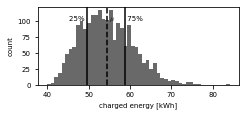

In [15]:
import matplotlib.pyplot as plt
# generate a histogram of the fuel consumption
pltSettings()
# make to subplots
#fig, (ax1, ax2) = plt.subplots(2,1)

ax = df_new["fuel"].plot.hist(bins=50, color = "dimgrey")
# plot 25 to 75 percentiles
quant = df_new["fuel"].quantile([0.25, 0.75])
ax.axvline(quant[0.25], color='k')
ax.axvline(quant[0.75], color='k')
# add text at 25 and 75 percentile
ax.text(quant[0.25], 100, "25% ", color='k', horizontalalignment='right')
ax.text(quant[0.75], 100, " 75%", color='k', horizontalalignment='left')
# add line at mean
ax.axvline(df_new["fuel"].mean(), color='k', linestyle='--')
# add text at mean
ax.text(df_new["fuel"].mean(), 100, " $\mu$", color='k', horizontalalignment='left')
ax.set_xlabel("charged energy [kWh]")
ax.set_ylabel("count")

# set fig size 
fig = plt.gcf()
fig.set_size_inches(plotSizeX, 1.2*plotSizeY)
# save figure
fig.savefig(figures_directory + os.sep + "histogram_fuel_consumption.pdf", bbox_inches='tight')

In [16]:
'''find out if there are differences how charging stations are used'''
# load the infrastructure file
df_infrastructure = pd.read_csv(path_infrastructure, index_col= "taz")
print('number of depots: ' + str(len(df_infrastructure)))
df_infrastructure.head()

number of depots: 159


,parkingType,pricingModel,chargingPointType,numStalls,feeInCents,reservedFor,parkingZoneId,locationX,locationY
taz,,,,,,,,,
519,Workplace,FlatFee,DepotXFC(300.0|DC),6,0,ridehail(GlobalRHM),depot-519-1,615674.118137,4.200071e+06
64,Workplace,FlatFee,DepotXFC(300.0|DC),7,0,ridehail(GlobalRHM),depot-64-2,588385.283722,4.155801e+06
1201,Workplace,FlatFee,DepotXFC(300.0|DC),10,0,ridehail(GlobalRHM),depot-1201-3,552182.141567,4.182212e+06
328,Workplace,FlatFee,DepotXFC(300.0|DC),4,0,ridehail(GlobalRHM),depot-328-4,562064.608759,4.238279e+06
884,Workplace,FlatFee,DepotXFC(300.0|DC),5,0,ridehail(GlobalRHM),depot-884-5,585560.733910,4.133864e+06


In [17]:
print(df_infrastructure["numStalls"].unique())

[ 6  7 10  4  5  1  3  2  9  8]


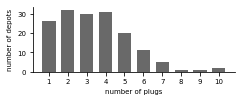

In [19]:
# make histogram about the distribution of numStalls
import matplotlib
import matplotlib.pyplot as plt
import os
plt.rcParams.update({'font.size': 7})
plt.rcParams['mathtext.fontset'] = 'cm'
df_infrastructure["numStalls"].hist(bins = range(1, max(df_infrastructure["numStalls"])+2, 1), histtype='bar', rwidth=0.7, color='dimgrey', align='left', grid=False)
# draw line around bars
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
#make x ticks every 1
plt.xticks(range(1, 11, 1))
plt.xlabel("number of plugs")
plt.ylabel("number of depots")
fig = plt.gcf()
fig.set_size_inches(plotSizeX, plotSizeY)
fig.savefig(figures_directory + os.sep + "histogram_numStalls.pdf", bbox_inches='tight', pad_inches=0.05)